In [113]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import NMF

In [187]:
df16 = pd.read_pickle("data/survey2016_final.pkl")
df17 = pd.read_pickle("data/survey2017_final.pkl")
df17 = df17[[isinstance(x, str) for x in df17.Country]]
df18 = pd.read_pickle("data/survey2018_final.pkl")
df19 = pd.read_pickle("data/survey2019_final.pkl")
survey_data = pd.concat([df16, df17, df18, df19], sort=True, ignore_index=True)

In [189]:
survey_data.head()

,Age,ConvertedSalary,Country,Gender,Hobby,JobSatisfaction,LanguageDesireNextYear,LanguageWorkedWith,StackOverflowParticipate,StackOverflowVisit,Year,YearsCoding
0,30-34,45000.0,AFG,Male,Yes,7.0,[Swift],"[iOS, Objective-C]",NA,Multiple times per day,2016,6 - 10 years
1,0,5000.0,AFG,Female,Yes,7.0,[],[],NA,A few times per week,2016,11+ years
2,0,210000.0,AFG,Prefer not to disclose,No,-1.0,[Android],"[Android, Arduino / Raspberry Pi, AngularJS,...",NA,Multiple times per day,2016,11+ years
3,25-29,5000.0,AFG,Male,No,7.0,"[Android, iOS]","[JavaScript, PHP, SQL, WordPress]",NA,A few times per week,2016,0 - 2 years
4,20-24,5000.0,ALB,Male,Yes,5.5,"[Android, iOS, Java, JavaScript, Node.js, ...",[PHP],NA,Multiple times per day,2016,0 - 2 years


In [190]:
mappings = {"HTML":"HTML/CSS", "CSS":"HTML/CSS", "Bash/Shell":"Bash/Shell/PowerShell"}
def cleanLanguage(lang):
    res = lang.strip()
    if res in mappings:
        res = mappings[res]
    return res
survey_data.LanguageWorkedWith = survey_data.LanguageWorkedWith.apply(lambda langs: list({cleanLanguage(lang) for lang in langs}))

In [191]:
languages = list(survey_data.explode("LanguageWorkedWith").LanguageWorkedWith.unique())
exploded = survey_data.explode("LanguageWorkedWith")
exploded.LanguageWorkedWith.fillna("Nothing", inplace=True)

In [192]:
exploded.LanguageWorkedWith = exploded.LanguageWorkedWith.apply(lambda l: l.strip())

In [193]:
langs = exploded[["LanguageWorkedWith"]]
langs["dummy"] = True

/home/severi/miniconda3/envs/ada/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [194]:
pivoted = langs.pivot(columns="LanguageWorkedWith")["dummy"]
pivoted.index.rename("", inplace=True)
pivoted.fillna(False, inplace=True)

In [195]:
pivoted.head()

LanguageWorkedWith,Android,AngularJS,Arduino / Raspberry Pi,Assembly,Bash/Shell/PowerShell,C,C#,C++,Cassandra,Clojure,...,Swift,TypeScript,VB.NET,VBA,Visual Basic,Visual Basic 6,WebAssembly,Windows Phone,WordPress,iOS
,,,,,,,,,,,,,,,,,,,,,
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,True,True,True,False,False,True,True,True,True,True,...,True,False,False,False,True,False,False,True,True,True
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [196]:
list(pivoted.columns)

['Android',
 'AngularJS',
 'Arduino / Raspberry Pi',
 'Assembly',
 'Bash/Shell/PowerShell',
 'C',
 'C#',
 'C++',
 'Cassandra',
 'Clojure',
 'Cloud (AWS, GAE, Azure, etc.)',
 'Cobol',
 'CoffeeScript',
 'Common Lisp',
 'Cordova',
 'Dart',
 'Delphi/Object Pascal',
 'Elixir',
 'Erlang',
 'F#',
 'Go',
 'Groovy',
 'HTML/CSS',
 'Hack',
 'Hadoop',
 'Haskell',
 'Java',
 'JavaScript',
 'Julia',
 'Kotlin',
 'LAMP',
 'Lua',
 'Matlab',
 'MongoDB',
 'Node.js',
 'Nothing',
 'Objective-C',
 'Ocaml',
 'Other(s):',
 'PHP',
 'Perl',
 'Python',
 'R',
 'ReactJS',
 'Redis',
 'Ruby',
 'Rust',
 'SQL',
 'SQL Server',
 'Salesforce',
 'Scala',
 'SharePoint',
 'Smalltalk',
 'Spark',
 'Swift',
 'TypeScript',
 'VB.NET',
 'VBA',
 'Visual Basic',
 'Visual Basic 6',
 'WebAssembly',
 'Windows Phone',
 'WordPress',
 'iOS']

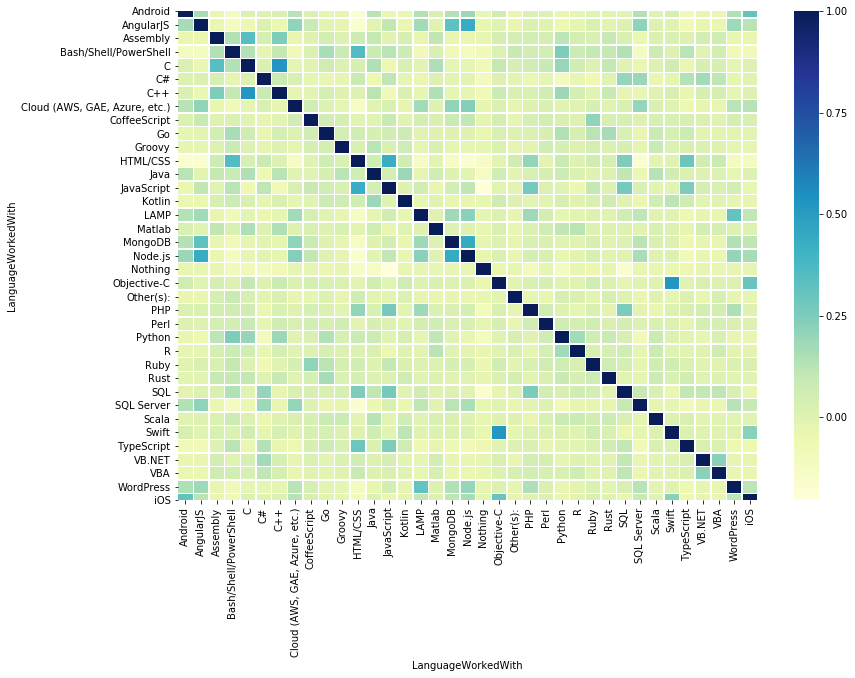

In [197]:
import seaborn as sns
common_langs = list(pivoted.sum()[pivoted.sum() > 4000].index)
plt.figure(figsize=(13,9))
ax = sns.heatmap(pivoted[common_langs].corr(), linewidth=0.5, cmap="YlGnBu")
plt.show()

In [198]:
nmf_model = NMF(6)
W = nmf_model.fit_transform(pivoted)

In [199]:
usertypes.Country

0         AFG
1         AFG
2         AFG
3         AFG
4         ALB
         ... 
246969    ITA
246970    CZE
246971    ESP
246972    USA
246973    ESP
Name: Country, Length: 246974, dtype: object

In [200]:
types = pd.DataFrame(nmf_model.components_, columns=pivoted.columns).T
usertypes = pd.DataFrame(W)
usertypes = survey_data[["Country"]].merge(usertypes, left_index=True, right_index=True)
type_by_country = usertypes.groupby("Country").mean()#.apply(lambda row: row/row.sum(), axis=1)

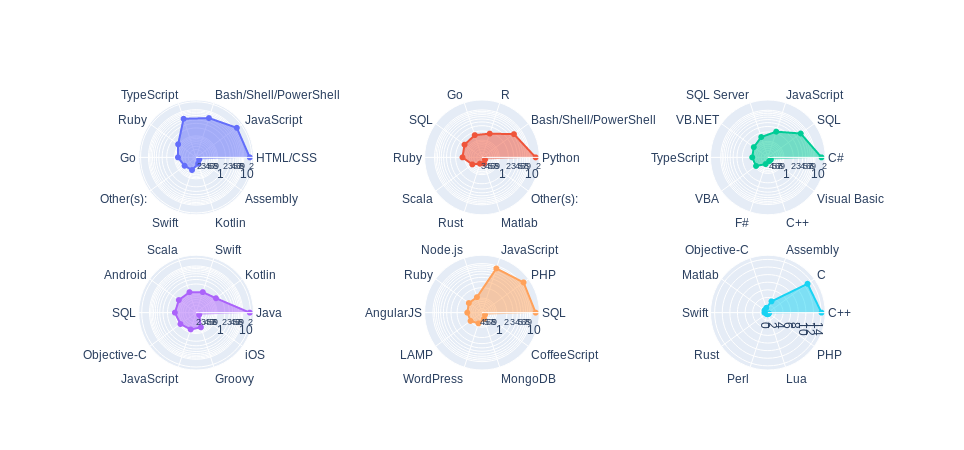

In [203]:
"""Plot the most significant programming languages for each user group"""

from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(rows=2, cols=3)
fig = make_subplots(
    rows=2, cols=3,
    specs=[[{"type": "polar"}, {"type": "polar"}, {"type": "polar"}],
           [{"type": "polar"}, {"type": "polar"}, {"type": "polar"}]],
)

for i in range(6):
    for_polar = types[i].nlargest(10)
    x = (i % 3 + 1)
    y = (int(i / 3) + 1)
    fig.add_trace(
        go.Scatterpolar(
            r=for_polar,
            theta=list(for_polar.index),
            fill='toself',
            mode="lines+markers+text",
            subplot="polar2"
        ),
        row=y, col=x
    )

#Apparently these can be formatted by 
subaxes = ["polar{}".format(i) if i != 0 else "polar" for i in range(6)]
fig.update_layout(
    {subax: dict(
        radialaxis=dict(
            visible=True,
            type="log"
        ),
    ) for subax in subaxes}
)

fig.update_layout(
    showlegend=False
)

fig.show()

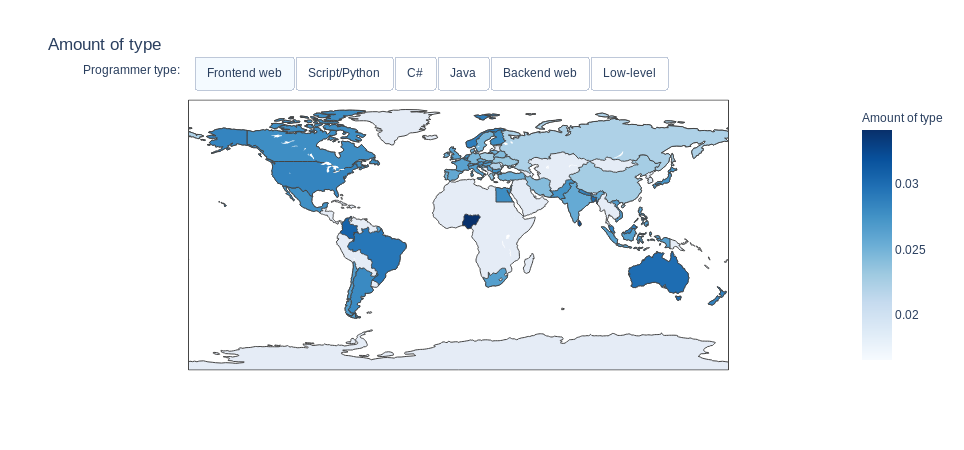

In [202]:
"""Plot the country scores for each programmer type"""
import plotly.graph_objects as go

fig = go.Figure()

for i in range(6):
    fig.add_trace(go.Choropleth(
        locations=type_by_country[survey_data.groupby("Country").count().Age > 500].index, # Spatial coordinates
        z = type_by_country[survey_data.groupby("Country").count().Age > 500][i], # Data to be color-coded
        #text=type_by_country[df19.groupby("Country").count().Age > 500][0],
        colorscale = 'Blues',
        colorbar_title = "Amount of type",
        name="2",
        visible=(i==0)
    ))

fig.update_layout(
    title_text = 'Amount of type'
)

# Add dropdown
prog_labels = ["Frontend web", "Script/Python", "C#", "Java", "Backend web", "Low-level"]
fig.update_layout(
    updatemenus=[
        go.layout.Updatemenu(
            type = "buttons",
            direction = "left",
            buttons=list([dict(
                    args=[{"visible" : [j==i for j in range(6)]}],
                    label=prog_labels[i],
                    method="update"
                ) for i in range(6) ]),
            pad={"r": 10, "t": 10},
            showactive=True,
            x=0.15,
            xanchor="left",
            y=1.2,
            yanchor="top"
        ),
    ]
)

# Add annotation
fig.update_layout(
    annotations=[
        go.layout.Annotation(text="Programmer type:", showarrow=False,
                             x=0, y=1.15, yref="paper", align="left")
    ]
)

fig.show()

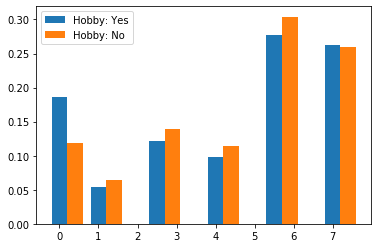

In [12]:
plt.figure()
satisfaction_hobby_yes = df19[df19.Hobby=="Yes"].groupby("JobSatisfaction").count().apply(lambda x: x/len(df19[df19.Hobby=="Yes"])).Gender
satisfaction_hobby_no = df19[df19.Hobby=="No"].groupby("JobSatisfaction").count().apply(lambda x: x/len(df19[df19.Hobby=="No"])).Gender
plt.bar(satisfaction_hobby_yes.index,satisfaction_hobby_yes, width=0.4)
plt.bar(satisfaction_hobby_no.index+0.4,satisfaction_hobby_no, width=0.4)
plt.legend(["Hobby: Yes", "Hobby: No"])
plt.show()

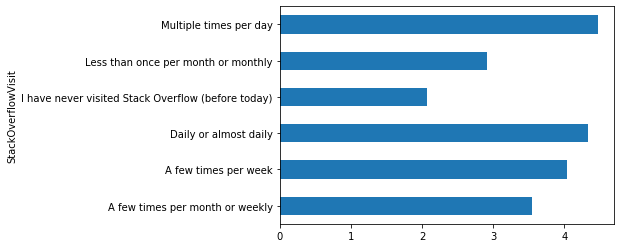

In [13]:
df19.groupby("StackOverflowVisit").mean().JobSatisfaction.drop("NA").plot.barh()

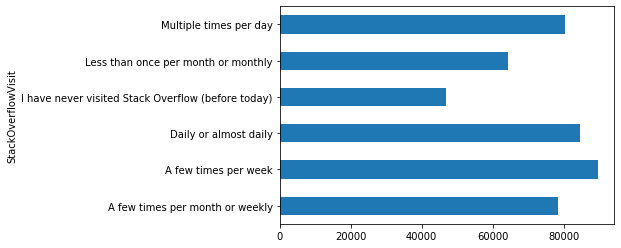

In [14]:
df19.groupby("StackOverflowVisit").mean().ConvertedSalary.drop("NA").plot.barh()

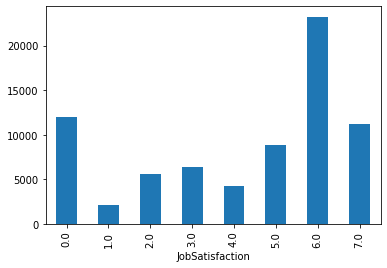

In [57]:
df18.groupby("JobSatisfaction").count().Age.plot.bar()